<a href="https://colab.research.google.com/github/Zaitun-dev/my_project/blob/main/bert_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [2]:
pip install -q transformers accelerate datasets torch pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.6 MB/s eta 0:00:00


In [59]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]


Saving reddit_iphone16_labeled.csv to reddit_iphone16_labeled (3).csv


In [61]:
#cleaning the csv file
import pandas as pd
import io

# Load your CSV file
df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Display some rows to inspect
print("Before cleaning:")
print(df.head())

# Drop rows with missing text
df = df.dropna(subset=["text"])

# Remove duplicates
df = df.drop_duplicates(subset=["text"])

# Strip leading/trailing whitespace
df["text"] = df["text"].str.strip()

# Drop very short texts (optional: less than 10 characters)
df = df[df["text"].str.len() > 10]

# Confirm label column exists and is clean
print("\nLabel distribution:")
print(df["label"].value_counts())

# Save cleaned version
df.to_csv("reddit_iphone16_cleaned.csv", index=False)

print("\n✅ CSV cleaned and saved as 'reddit_iphone16_cleaned.csv'")


Before cleaning:
                                               title  \
0  Why I sold my iPhone 16 pro and left apple for...   
1  The iPhone 16 isn’t trash, you just need to st...   
2                               Is iPhone 16 a flop?   
3                 Opinion on iPhone 16 having 60 hz?   
4                          iPhone 16 - What a trash!   

                                                text  score  num_comments  \
0                                                NaN   3136           853   
1  Non stop I keep seeing post/videos all over so...   1101           254   
2  I have an iPhone 11 and I was planning to repl...      1            41   
3  Do you think apple is being stubborn or is the...   2435          1330   
4  Just new color, add a button. No innovation. L...     52           148   

                                                 url   created_utc     label  
0                https://i.redd.it/gshhh7tscmke1.png  1.740199e+09   neutral  
1  https://www.reddit.com

In [62]:
import pandas as pd
from google.colab import files
import io

#upload the file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

#read the file
df = pd.read_csv(io.BytesIO(uploaded[filename]))

#keep the column we need
df = df[['text', 'label']].dropna(subset=['text', 'label'])

#map the sentiment to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label'].map(label_map)
df.head()


Saving reddit_iphone16_cleaned.csv to reddit_iphone16_cleaned (1).csv


,text,label
0,Non stop I keep seeing post/videos all over so...,1
1,I have an iPhone 11 and I was planning to repl...,2
2,Do you think apple is being stubborn or is the...,0
3,"Just new color, add a button. No innovation. L...",1
4,There have been a lot people trying to justify...,2


In [63]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.2)


In [64]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length',max_length=128)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/23 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [65]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
#

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
from transformers import Trainer
import torch

class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, num_items_in_batch=None, return_outputs=False): # Add num_items_in_batch
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Apply class weights to the loss function
        try:
            loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        except NameError:
             # Handle the case where class_weights is not defined
             # This could happen if class_weights was defined in a different cell
             # You might want to raise an error or handle it appropriately
             print("Error: 'class_weights' is not defined. Ensure it's accessible in compute_loss.")
             raise
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [57]:
from transformers import TrainingArguments
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
os.environ["WANDB_DISABLED"] = "true"

labels = df['label'].values
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(class_weights)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,  #increased the number of training epoch
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",  # <--- disables W&B
    eval_strategy="epoch", #eval_strategy to evaluate at the end of each epoch
    save_strategy="epoch" #save_strategy to save the model at the end of each epoch
)
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)



tensor([3.6667, 0.6875, 0.7857])


In [67]:
trainer.train()

#save the model
trainer.save_model()

#save tokenizer
tokenizer.save_pretrained(trainer.args.output_dir)

#evaluate on the test set
eval_results = trainer.evaluate()
print(eval_results)

#save the model



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.979386,0.571429,0.595238,0.571429,0.571429
2,No log,0.979117,0.571429,0.595238,0.571429,0.571429
3,No log,0.978567,0.571429,0.595238,0.571429,0.571429
4,No log,0.977954,0.571429,0.595238,0.571429,0.571429
5,No log,0.976866,0.571429,0.595238,0.571429,0.571429
6,No log,0.975801,0.571429,0.595238,0.571429,0.571429


{'eval_loss': 0.9758013486862183, 'eval_accuracy': 0.5714285714285714, 'eval_precision': 0.5952380952380951, 'eval_recall': 0.5714285714285714, 'eval_f1': 0.5714285714285714, 'eval_runtime': 0.083, 'eval_samples_per_second': 84.289, 'eval_steps_per_second': 12.041, 'epoch': 6.0}


predicting sentiment on a new text from reddit

In [68]:
from transformers import pipeline
from transformers import BertForSequenceClassification, BertTokenizer
import torch

model_path = trainer.args.output_dir
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
model_path = trainer.args.output_dir
#injected the label mapping in training model
#load the trained model and and tokenizer
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)



#create sentiment analysis pipeline
# Pass the label_map to the pipeline using id2label
sentiment_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer )
#test the input
texts_to_test =  [
                  "The iphone 16 is overpriced",
                  "The iphone 16 is okay, not too exciting"


]
for text in texts_to_test:
    print(f"Input Text: {text}")
    prediction = sentiment_pipeline(text)
    print(f"Prediction: {prediction}")
    print("-" * 20)



Device set to use cuda:0


Input Text: The iphone 16 is overpriced
Prediction: [{'label': 'positive', 'score': 0.4301779270172119}]
--------------------
Input Text: The iphone 16 is okay, not too exciting
Prediction: [{'label': 'neutral', 'score': 0.3935059905052185}]
--------------------


saving predictions to a file

In [71]:
import pandas as pd
texts = ["I love the iphone 16. It's amazing"
         "The iphone 16 is overpriced"
         "The iphone 16 is okay, not too exciting"
         ]

predictions = sentiment_pipeline(texts)
#create a dataframe
df = pd.DataFrame({
    "text": texts,
    "label": [p['label'] for p in predictions], # Keep the pipeline's label (string)
    "score": [p['score'] for p in predictions],
    # Directly use the string label from the pipeline output for the 'sentiment' column
    "sentiment": [p['label'] for p in predictions]
})
#save to csv
df.to_csv("sentiment_predictions.csv", index=False)
print("Predictions saved to sentiment_predictions.csv")


Predictions saved to sentiment_predictions.csv


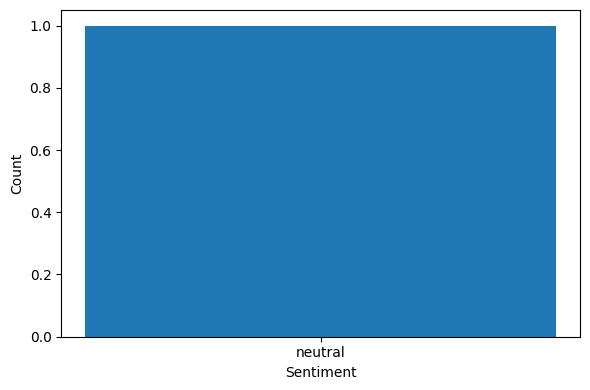

In [72]:
import matplotlib.pyplot as plt
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


building a simple web interface

In [2]:
pip install -q gradio==3.50.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 118.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.61 requires websockets>=13.0, but you have websockets 11.0.3 which is incompatible.
thinc 8.3.6 requ

In [3]:
import gradio as gr

def predict_sentiment(text):
    result = sentiment_pipeline(text)[0]
    label = label_map.get(result['label'], result['label'])
    return f"{label} ({result['score']:.2f})"

#create gradio interface
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, placeholder="Enter text here..."),
    outputs="text",
    title="Iphone 16 Sentiment Analysis",
)
interface.launch()


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject